# Approximation through the empirical interpolation method (EIM)

The empirical interpolation method (EIM) seeks to approximate a family of parametric functions using a sensibly chosen linear space of moderate dimension, and some interpolation points. Any function in this parametric family can then be approximated globally by simply evaluating it at the interpolation points, then filling in using the linear interpolator.

[Insert: some nice graphics here]

### First we need to do a little housekeeping

We import the libraries we require:

In [1]:
import numpy as np
import math
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm 
from mpl_toolkits.mplot3d import axes3d, Axes3D
from IPython.display import Latex, display

%matplotlib inline

This following snippet stops the automatic cutting of cell output when it gets too long:

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Let us define a little helper function for plotting our functions on grids

In [3]:
cmap = cm.inferno

def plot_R2_function(vals, ax, title=None):
    # A routine that just plots a function that is assumed to be evaluated on a the grid of points
    # with optional title
    wframe = ax.plot_surface(x1_grid, x2_grid, vals, cstride=5, rstride=5, alpha=0.7, cmap=cmap)
    # (note that x1_grid and x2_grid will be defined later)
    ax.set_facecolor('white')    
    #ax.set_xlabel('$x_1$')
    #ax.set_ylabel('$x_2$')
    
    if title is not None:
        ax.set_title(title)

# Step 1 - Lets get started! 
### First we need to define a family of functions that we want to interpolate

Lets start with a simple family of parametric functions given by

$$
\large
g(x, \mu) = \frac{2}{\| x - \mu \|}
$$

where $\large x \in \mathcal{X} = [0,1]^2$ is two dimensional, and the parameter  $\large \mu \in \mathcal{Y} = [1.1, 2.1]^2$ 

(We can define whatever we want for $\mathcal{X}$ in ```x_lims``` or for $\mathcal{Y}$ in  ```mu_lims```).

Below we define a grid for $x$ on $\mathcal{X} = [0,1]^2$, and a grid of possible parameters $\mu$ in $\mathcal{Y} = [1.1, 2.1]^2$.

In [4]:
x_lims = [[0,1], [0,1]]
mu_lims = [[1.1, 2.1], [1.1, 2.1]]

n_mu_grid = 100
n_x_grid = 100

mu1_grid, mu2_grid = np.meshgrid(np.linspace(mu_lims[0][0], mu_lims[0][1], n_mu_grid+1,endpoint=True), 
                                 np.linspace(mu_lims[1][0], mu_lims[1][1], n_mu_grid+1,endpoint=True))
x1_grid, x2_grid = np.meshgrid(np.linspace(x_lims[0][0],x_lims[0][1],n_x_grid+1,endpoint=True), 
                               np.linspace(x_lims[1][0],x_lims[1][1],n_x_grid+1,endpoint=True))

# We make a flattened list of all the points in the grid for x or mu
# If we call mu_grid_list[i] we will get an array of length 2, [mu_1, mu_2] 
mu_grid_list = np.vstack((mu1_grid.flatten(), mu2_grid.flatten())).T
x_grid_list = np.vstack((x1_grid.flatten(), x2_grid.flatten())).T

# Just how many possible parameters have we generated?
print('Number of mu parameters in grid:', mu_grid_list.shape[0])

Number of mu parameters in grid: 10201


<IPython.core.display.Latex object>

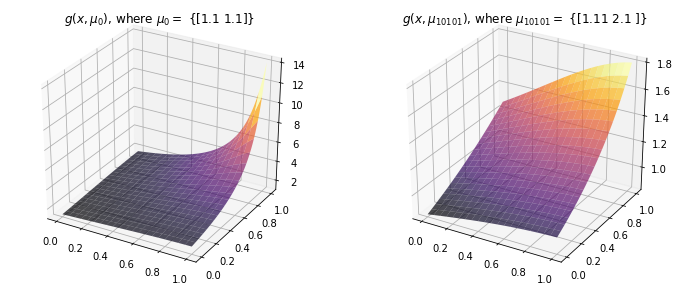

In [5]:
def g(x, mu):
    # This definition of g can take a list of multiple values for x or mu
    # provided we have wither the same number of x or mu, or have one x and multiple mu,
    # or one mu and multiple mu (because of the behaviour of np.linalg.norm with axis=1)
    return 2.0 / np.linalg.norm(x - mu, axis=1)

def eval_g_on_grid(mu):
    # This evaluates g on the grid using the pre-computed x_grid_list
    return g(x_grid_list, mu).reshape((n_x_grid+1, n_x_grid+1))

def norm(func_vals):
    # A little helper function that calculates the L^2 norm of a function that
    # is evaluated on the regular x grid.
    
    #if vals.ndim > 2:
    #    return np.linalg.norm(vals, axis=(1,2)) / (N_x_grid * N_x_grid)
    #else:
    
    return np.linalg.norm(func_vals) / (n_x_grid * n_x_grid)

display(Latex(r'We plot two instances of $g(x,\mu)$'))

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot_R2_function(eval_g_on_grid(mu_grid_list[0]), ax, 
                 title=rf'$g(x,\mu_{{0}})$, where $\mu_{{0}} = $ {{{mu_grid_list[0]}}}')

ax = fig.add_subplot(1, 2, 2, projection='3d')
plot_R2_function(eval_g_on_grid(mu_grid_list[10101]), ax, 
                 title=rf'$g(x,\mu_{{10101}})$, where $\mu_{{10101}} = $ {{{mu_grid_list[10101]}}}')
plt.show()

# Step 2: Generate a training set 

By evaluating the function $g(x, \mu)$ for each $\mu$ in a set of parameters $\mathcal{T} \subset \mathcal{Y}$. 

We can take $\mathcal{T}$ to simply be the list of grid points ```mu_grid_list```, defined earlier. These evaluations of $g(x, \mu_i)$ are saved in ```training_set```.

The number of training set points $N$ is determined by the grid we defined earlier...

In [6]:
# This is the training set: a collection 
training_set = np.array([eval_g_on_grid(mu) for mu in mu_grid_list])

print('training set array size: ', training_set.shape)

# This array will be used in the loop - the "residual" from the interpolation of each
# element in the training set is saved here
training_set_resids = np.zeros(training_set.shape)

N = training_set.shape[0]
print('N =', N, 'is the number of training set points')

training set array size:  (10201, 101, 101)
N = 10201 is the number of training set points


# Step 3 - Define routines to assemble $\mathbf{B}$ and the interpolation $\mathcal{I}_n(g)$

There are two crucial steps in EIM. The first is assembling the matrix $\mathbf{B}$, for some selection of interpolation functions $q_j$ and interpolation points $x_i$. The interpolator that we wish to construct is a linear system of the form

$$
\large
\mathcal{I}_n( g(x, \mu) ) = \sum_{j=1}^n {\alpha_j(\mu)} \, { q_j(x)}
$$

This matrix is used in the next step of evaluating the interpolator $\mathcal{I}_n(q)$. We require our interpolation scheme to be exact for any $g \in V_n = \mathrm{span}(q_1, \ldots, q_n)$, that is we require
$$
\large
\mathcal{I}_n( g(x_i, \mu) ) = g(x_i, \mu)
$$

This means that we enforce
$$
\large
\sum_{j=1}^n \alpha_j(\mu) \, q_j(x_i) = g(x_i, \mu)
$$
which is equivalent to the linear system
$$
\large
\mathbf{B} \mathbf{\alpha} = \mathbf{g}
$$

where $\mathbf{B} \in \mathbb{R}^{n\times n}$ is the matrix with values $\mathbf{B}_{i,j} = q_j(x_i)$ and $\mathbf{\alpha}, \mathbf{g} \in \mathbb{R}^n$ are the coefficient vectors given above.

We will define two routines:
 - ```build_B_matrix``` that constructs $\mathbf{B}$, and
 - ```interpolator``` that takes the inverse $\mathbf{B}^{-1}$ and uses it to calculate the coefficients $\alpha_i(\mu)$, which are labelled ```alpha_coeffs[i]``` in the code. To calculate ```alpha_coeffs``` we require the function $g$ evaluated at the points $x_i$, which we
 
__Question__: Why would we define $\mathbf{B}$ separately and then use its inverse $\mathbf{B}^{-1}$, rather than just calling a linear solver line ```np.linalg.solve```?

In [7]:
def build_B_matrix(selected_qs, selected_xs):

    # Make the B matrix
    B = np.zeros((len(selected_xs), len(selected_qs)))
    for i in range(len(selected_xs)):
        for j in range(len(selected_qs)):
            B[i, j] = selected_qs[j][selected_xs[i]]
            
    return B

def interpolator(g, B_inv, interp_funs, interp_points):
    
    # First we must evaluate g at the interp_points
    g_eval = np.zeros(len(interp_points))
    for i, interp_point in enumerate(interp_points):
        g_eval[i] = g[interp_point]

    # Now we apply B_inv to be able to calculate the EIM coefficients
    alpha_coeffs = B_inv @ g_eval
    interpolant = np.zeros(g.shape)
    
    # We construct the interpolant from these coefficients
    for i in range(len(interp_points)):
        interpolant += alpha_coeffs[i] * interp_funs[i]
    return interpolant

# Step 4 - implement the iterative steps of the EIM.

### Our first iteration:

$$ \large
\begin{aligned}
\mu_1 &= \arg \max \{ \| g(x, \mu) \| : \mu \in \mathcal{T} \} \\
x_1 &= \arg \max \{ | g(x, \mu_1) | : x\in\mathcal{X}  \} \\
q_1 &:= \frac{g(x; \cdot)} { g(x_1; \mu_1)}
\end{aligned}
$$

### Then at iteration $n$

Assume we have built a collection of interpolation functions $(q_1,\ldots,q_{n-1})$ and interpolation points $(x_1,\ldots,x_{n-1})$. From these we can define $\mathcal{I}_{n-1}[g(x, mu)]$ as in __Step 3__. Then we find

$$ \large
\begin{aligned}
\mu_n &= \arg\max_{\mu \in \mathcal{T}}  \| g(x, \mu) - \mathcal{I}_{n-1}[ g(x, \mu) ] \| \\
x_n &= \arg\max_{x\in\mathcal{X}} | g(x, \mu_n) | \\
q_n &:= \frac{g(x, \mu_n) - \mathcal{I}_{n-1}[g(x, \mu_n)]} { g(x_n, \mu_n) - \mathcal{I}_{n-1}[g(x_n, \mu_n)]}
\end{aligned}
$$

Lets look at coding this in steps below. Lets do the first iteration first. Note that we are saving the interpolation functions $\large q_i$ in the list ```interp_funs``` and the interpolation points $\large x_i$ in the list ```interp_points```

<IPython.core.display.Latex object>

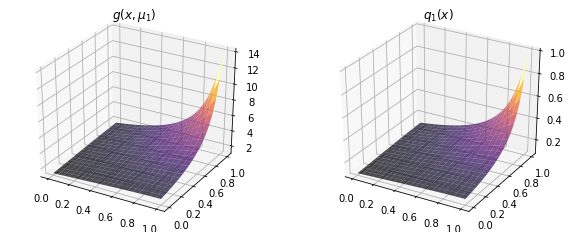

In [8]:
n_iter = 6 # The number of iterations = num of interpolation points

selected = []
interp_funs = []
interp_points = []

norms = np.array([norm(u) for u in training_set])

first_choice = np.argmax(norms)

selected.append(first_choice)

first_x = np.unravel_index(np.argmax(training_set[first_choice]), training_set[first_choice].shape)
interp_points.append(first_x)

interp_funs.append(training_set[first_choice] / training_set[first_choice][first_x])

# Lets take a look:
display(Latex(r'We plot the first choice $g(x, \mu_1)$, and label $x_1$, as well as $q_1(x)$'))

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot_R2_function(training_set[first_choice], ax, title = rf'$g(x, \mu_1)$')

ax = fig.add_subplot(1, 2, 2, projection='3d')
plot_R2_function(interp_funs[-1], ax, title = rf'$q_1(x)$')
plt.show()

Now we go on with the next iterations

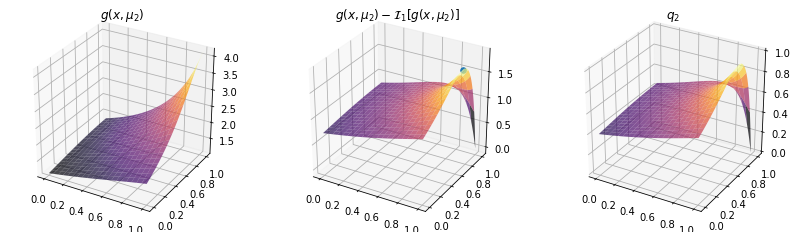

<IPython.core.display.Latex object>

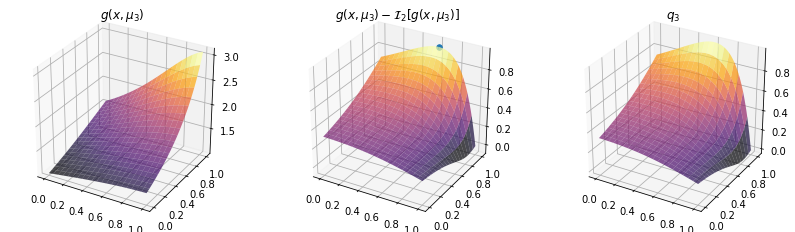

<IPython.core.display.Latex object>

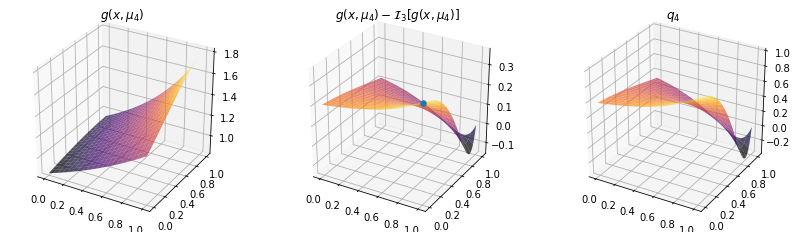

<IPython.core.display.Latex object>

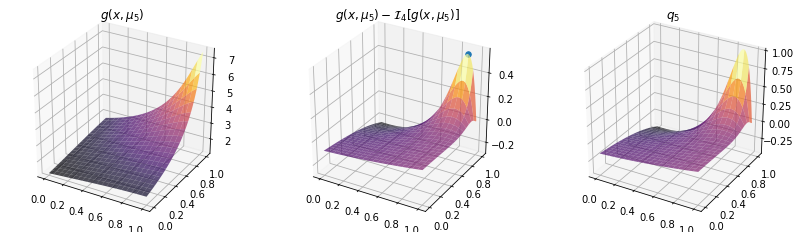

<IPython.core.display.Latex object>

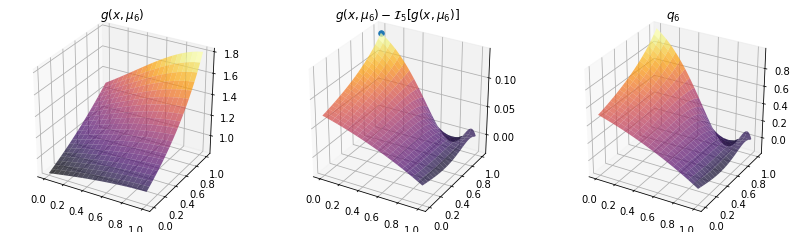

<IPython.core.display.Latex object>

In [9]:
for n in range(2,n_iter+1):
    
    B = build_B_matrix(interp_funs, interp_points)
    B_inv = np.linalg.inv(B)
    
    # Now we can construct the vector for each function
    resids = np.zeros(training_set.shape[0])
    for g_i, g in enumerate(training_set):
        
        interpolant = interpolator(g, B_inv, interp_funs, interp_points)
        resids[g_i] = norm(g - interpolant)
    
    next_choice = np.argmax(resids)
    selected.append(next_choice)
    
    selected_g = training_set[next_choice]
    selected_g_resid = selected_g - interpolator(selected_g, B_inv, interp_funs, interp_points)
    
    # Now choose x_n - note that it is an index of where the maximum is located on the grid
    next_x = np.unravel_index(np.argmax(selected_g_resid), selected_g_resid.shape)
    interp_points.append(next_x)
    
    next_q = selected_g_resid / selected_g_resid[next_x]
    interp_funs.append(next_q)
    
    fig = plt.figure(figsize=(14, 4))
    ax = fig.add_subplot(1, 3, 1, projection='3d')
    plot_R2_function(training_set[next_choice], ax, title = rf'$g(x, \mu_{{{n}}})$')
    ax = fig.add_subplot(1, 3, 2, projection='3d')
    plot_R2_function(selected_g_resid, ax, 
                     title = rf'$g(x, \mu_{{{n}}}) - \mathcal{{I}}_{{{n-1}}}[g(x, \mu_{{{n}}})]$')

    ax.scatter(next_x[1]/n_x_grid, next_x[0]/n_x_grid, selected_g_resid[next_x], s=30)
    ax = fig.add_subplot(1, 3, 3, projection='3d')
    plot_R2_function(interp_funs[-1], ax, title = rf'$q_{{{n}}}$')
    plt.show()
    
    display(Latex(rf'The point $x_{{{n}}}$ is at index {next_x} which ' +
                  rf'gives the coordinate $x_{{{n}}} = {{{next_x[1]/n_x_grid, next_x[0]/n_x_grid}}}$'))

# Step 5 - Lets look at some results:

 - Plot $L^\inf$ convergence rate
 - Plot the Lebesgue constant (given by a closed form expression
 
Included should be a discussion of the Lebesgue constant here and why it's relevant

# Step 6 - Bonus: 
### Solve a family of parametric PDEs and apply the EIM